In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [3]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("Resources/cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [4]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [5]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Returns'] = cad_jpy_df['Price'].pct_change()*100
cad_jpy_df = cad_jpy_df.replace(-np.inf, np.nan).dropna()
cad_jpy_df

,Price,Open,High,Low,Returns
Date,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901
...,...,...,...,...,...
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508


### Lagged Returns 

In [6]:
# Create a lagged return using the shift function and dropna
cad_jpy_df['Lagged_return'] = cad_jpy_df['Returns'].shift(periods=-1)
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df

,Price,Open,High,Low,Returns,Lagged_return
Date,,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720,-1.468476
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,0.874777
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-0.216798
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.667901
1990-01-09,125.10,125.04,125.10,125.04,0.667901,0.567546
...,...,...,...,...,...,...
2020-05-28,78.23,78.35,78.52,78.04,-0.114913,0.076697
2020-05-29,78.29,78.21,78.41,77.75,0.076697,1.251756
2020-06-01,79.27,78.21,79.36,78.04,1.251756,1.425508


### Train Test Split

In [7]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [8]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
y_train = train['Lagged_return'].to_frame()
X_train = train.drop(['Lagged_return'], axis=1)
y_test = test['Lagged_return'].to_frame()
X_test = test.drop(['Lagged_return'], axis=1)

In [9]:
# Preview the X_train data
X_train

,Price,Open,High,Low,Returns
Date,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901
...,...,...,...,...,...
2017-12-25,88.99,89.03,89.12,88.89,0.033723
2017-12-26,89.23,88.98,89.28,88.94,0.269693
2017-12-27,89.58,89.23,89.75,89.17,0.392245


# Linear Regression Model

In [10]:
# Create a Linear Regression model and fit it to the training data
lr_model = LinearRegression()

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
lr_fit = lr_model.fit(X = X_train, y = y_train)

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [11]:
# Make a prediction of "y" values using just the test dataset, convert to df and rename column
predictions = pd.DataFrame(lr_fit.predict(X_test)).rename(columns = {0:'predictions'})
predictions

,predictions
0,-0.017604
1,-0.013612
2,-0.016596
3,-0.022285
4,-0.012200
...,...
628,0.015684
629,0.006592
630,-0.007572
631,-0.011687


In [12]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
y_test = y_test.reset_index(drop=False)
results = pd.concat([y_test, predictions], axis = 1, join = 'inner').set_index('Date')
results

,Lagged_return,predictions
Date,,
2018-01-01,-0.055679,-0.017604
2018-01-02,0.011142,-0.013612
2018-01-03,0.601604,-0.016596
2018-01-04,0.919158,-0.022285
2018-01-05,-0.087787,-0.012200
...,...,...
2020-05-28,0.076697,0.015684
2020-05-29,1.251756,0.006592
2020-06-01,1.425508,-0.007572


array([<AxesSubplot:xlabel='days', ylabel='returns'>,
       <AxesSubplot:xlabel='days', ylabel='returns'>], dtype=object)

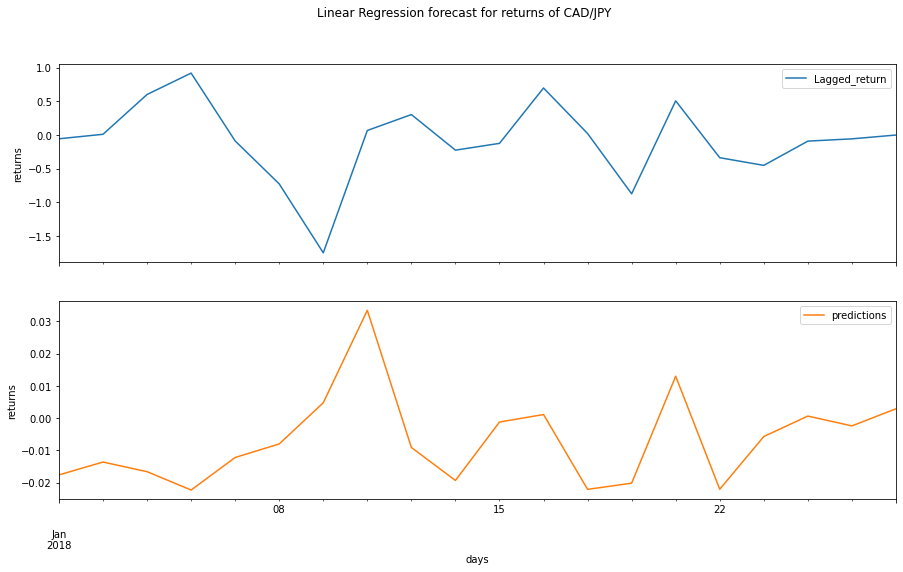

In [17]:
# # Plot the first 20 predictions vs the true values
results.iloc[:20].plot(subplots=True, figsize=(15,8), xlabel = 'days', ylabel = 'returns', title='Linear Regression forecast for returns of CAD/JPY')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [20]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(y_true=results.Lagged_return, y_pred=results.predictions)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
rmse

0.6447339797288155

# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [26]:
# Construct a dataframe using just the "y" training data:
ins_predictions = pd.DataFrame(lr_fit.predict(X_train)).rename(columns = {0:'predictions'})
y_train = y_train.reset_index(drop=False)
ins_results = pd.concat([y_train, ins_predictions], axis = 1, join = 'inner').set_index('Date')

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
ins_mse = mean_squared_error(y_true=ins_results.Lagged_return, y_pred=ins_results.predictions)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
ins_rmse = np.sqrt(ins_mse)
ins_rmse

0.8413290986937321

# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

A higher RMSE means the model is a predictor of the data, an RMSE of 0.64 for out of sample data as opposed to 0.84 for in sample data suggests the model performs better with in sample data.